# CUSTOMER SEGMENTATION USING RFM ANALYSIS & KNN CLUSTERING

# DATA PRE - PROCESSING

In [47]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')  # Ignore warning messages

import pandas as pd  # Import pandas library for data manipulation
import numpy as np  # Import numpy library for numerical operations
import datetime as dt  # Import datetime module for working with dates and times
from operator import attrgetter  # Import attrgetter function for attribute access

from sklearn.cluster import KMeans  # Import KMeans algorithm for clustering
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling

import matplotlib.pyplot as plt  # Import matplotlib for basic plotting
import seaborn as sns  # Import seaborn for statistical data visualization
import plotly.express as px  # Import plotly express for interactive plots
import plotly.graph_objects as go  # Import plotly graph objects for more customization
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting

In [48]:
# Define the file path for the CSV file
csv_file_path = 'data.csv'

# Attempt to read the CSV file using utf-8 encoding
try:
    df = pd.read_csv(csv_file_path, encoding='utf-8')

# Handle UnicodeDecodeError by reading the CSV file using latin-1 encoding if utf-8 fails
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding='latin-1')

# Display the first few rows of the DataFrame
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [49]:
df.isnull().sum() # Check and count the number of null values in each column of the DataFrame

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
df = df.dropna(subset=['CustomerID']) # Drop rows with null values in the 'CustomerID' column

In [51]:
df.duplicated().sum() # Check and count the number of duplicated rows in the DataFrame

5225

In [52]:
df = df.drop_duplicates() # Drop duplicate rows from the DataFrame

In [53]:
df.describe() # Generate descriptive statistics of the DataFrame, including count, mean, std, min, 25%, 50%, 75%, and max


,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


# CALCULATION OF RFM

In [43]:
# Import necessary libraries
from datetime import datetime
import pandas as pd

# Assuming df is your DataFrame with columns 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', and 'Country'

# Define a reference date for calculating recency
present = datetime(2024, 1, 15)

# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate recency by subtracting the maximum 'InvoiceDate' for each customer from the reference date
recency_df = (present - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days

# Calculate frequency by counting the unique 'StockCode' for each customer
frequency_df = df.groupby('CustomerID')['StockCode'].nunique()

# Calculate monetary value by summing the product of 'Quantity' and 'UnitPrice' for each customer
monetary_df = df.groupby('CustomerID')['Quantity'].sum() * df.groupby('CustomerID')['UnitPrice'].mean()

# Create a new DataFrame 'rfm_df' containing CustomerID, Recency, Frequency, and Monetary columns
rfm_df = pd.DataFrame({
    'CustomerID': recency_df.index,
    'Recency': recency_df.values,
    'Frequency': frequency_df.values,
    'Monetary': monetary_df.values,
})

# Display the first few rows of the resulting RFM DataFrame
rfm_df.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,4744,1,0.000000
1,12347.0,4421,103,6498.979011
2,12348.0,4494,22,13495.487419
3,12349.0,4437,73,5230.384932
4,12350.0,4729,17,756.711765


In [13]:
df1 = df[['CustomerID','InvoiceDate','Quantity','UnitPrice']]

In [182]:
df1

,CustomerID,InvoiceDate,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,6,2.55
1,17850.0,2010-12-01 08:26:00,6,3.39
2,17850.0,2010-12-01 08:26:00,8,2.75
3,17850.0,2010-12-01 08:26:00,6,3.39
4,17850.0,2010-12-01 08:26:00,6,3.39
...,...,...,...,...
541904,12680.0,2011-12-09 12:50:00,12,0.85
541905,12680.0,2011-12-09 12:50:00,6,2.10
541906,12680.0,2011-12-09 12:50:00,4,4.15
541907,12680.0,2011-12-09 12:50:00,4,4.15


# OUTLIER DETECTION & REMOVAL

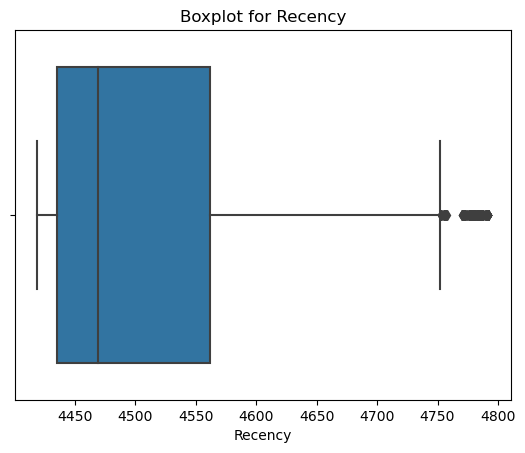

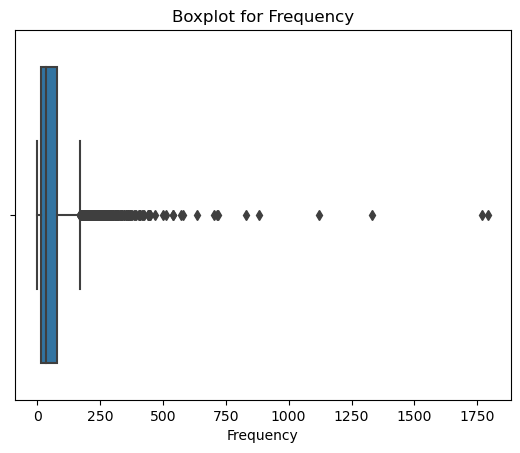

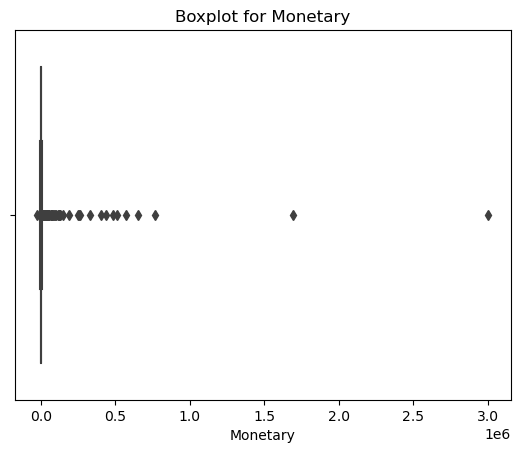

In [57]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# List of column names for which boxplots will be created
list1 = ['Recency', 'Frequency', 'Monetary']

# Iterate through each column in the list
for column in list1:
    # Create a boxplot for the current column
    sns.boxplot(x=rfm_df[column])

    # Add a title to the boxplot indicating the current column
    plt.title(f'Boxplot for {column}')
    plt.show()

In [58]:
import numpy as np

def remove_outliers(data, col):
    # Calculate the third and first quartiles
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    print(f"IQR value for column {col} is: {IQR}")

    # Define lower and upper ranges to identify outliers
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    print(lower_range, upper_range)
    
    # Replace outliers with the nearest limit within the range
    data[col] = np.clip(data[col], lower_range, upper_range)

    return data

In [56]:
final_recency = removeOutliers(rfm_df,'Recency')
final_frequency = removeOutliers(final_recency,'Frequency')
final_rfm_df = removeOutliers(final_frequency,'Monetary')

IQR value for column Recency is: 127.0
4244.5 4752.5
IQR value for column Frequency is: 62.0
-78.0 170.0
IQR value for column Monetary is: 2267.7856272910553
-2943.1617221865827 6127.980786977638


Recency before and after outlier capping using IQR


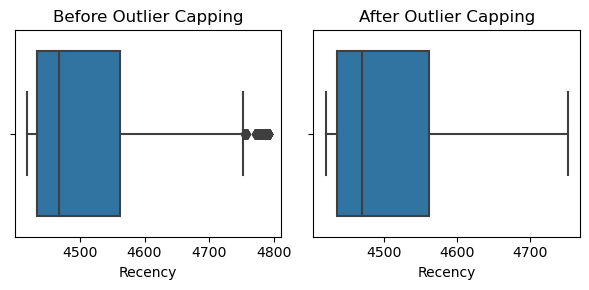

Frequency before and after outlier capping using IQR


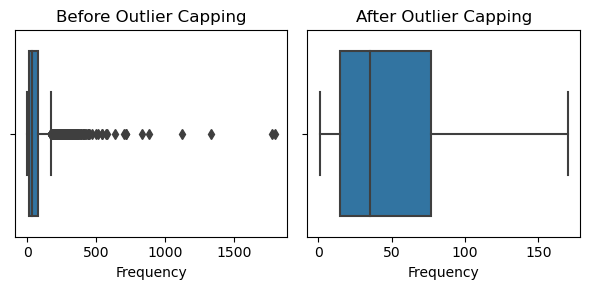

Monetary before and after outlier capping using IQR


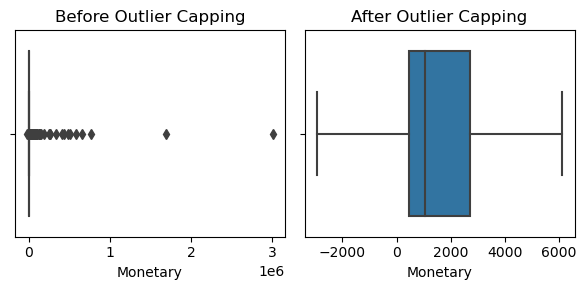

In [84]:
# Iterate through each column in the list
for col in ['Recency', 'Frequency', 'Monetary']:
    # Print column names before and after outlier capping
    print(f'{col} before and after outlier capping using IQR')
    
    # Create a figure with two subplots side by side
    plt.figure(figsize=(6, 3))
    
    # Plot the boxplot before outlier capping
    plt.subplot(1, 2, 1)
    sns.boxplot(x=rfm_df[col])
    plt.title(f'Before Outlier Capping')
    
    # Plot the boxplot after outlier capping
    plt.subplot(1, 2, 2)
    sns.boxplot(x=final_rfm_df[col])
    plt.title(f'After Outlier Capping')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# CALCULATE RFM SCORES BASED ON QUARTILE RANKING

In [60]:
# Define function to assign quartile scores
def assign_quartile_score(value, quartiles):
    if value <= quartiles[0]:
        return 4
    elif value <= quartiles[1]:
        return 3
    elif value <= quartiles[2]:
        return 2
    else:
        return 1

# Calculate quartiles for each RFM metric
recency_quartiles = final_rfm_df['Recency'].quantile([0.25, 0.5, 0.75]).values
frequency_quartiles = final_rfm_df['Frequency'].quantile([0.25, 0.5, 0.75]).values
monetary_quartiles = final_rfm_df['Monetary'].quantile([0.25, 0.5, 0.75]).values

# Assign quartile scores to each customer
final_rfm_df['Recency_Score'] = final_rfm_df['Recency'].apply(assign_quartile_score, args=(recency_quartiles,))
final_rfm_df['Frequency_Score'] = final_rfm_df['Frequency'].apply(assign_quartile_score, args=(frequency_quartiles,))
final_rfm_df['Monetary_Score'] = final_rfm_df['Monetary'].apply(assign_quartile_score, args=(monetary_quartiles,))

# Combine the RFM scores into a single RFM score
final_rfm_df['RFM_Score'] = (
    final_rfm_df['Recency_Score'].astype(str) +
    final_rfm_df['Frequency_Score'].astype(str) +
    final_rfm_df['Monetary_Score'].astype(str)
)

# Append 'CustomerID' to the DataFrame
final_rfm_df['CustomerID'] = rfm_df.index

# Display the DataFrame with RFM scores and 'CustomerID'
print(final_rfm_df[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score']].head())

   CustomerID  Recency  Frequency     Monetary  Recency_Score  \
0           0   4744.0        1.0     0.000000              1   
1           1   4421.0      103.0  6127.980787              4   
2           2   4494.0       22.0  6127.980787              2   
3           3   4437.0       73.0  5230.384932              3   
4           4   4729.0       17.0   756.711765              1   

   Frequency_Score  Monetary_Score RFM_Score  
0                4               4       144  
1                1               1       411  
2                3               1       231  
3                2               1       321  
4                3               3       133  


In [85]:
# Display unique values of the 'RFM_Score' column
display(final_rfm_df['RFM_Score'].unique())

# Print the number of unique values in the 'RFM_Score' column
print(f"Number of unique RFM scores: {final_rfm_df['RFM_Score'].nunique()}")

array(['144', '411', '231', '321', '133', '122', '143', '311', '442',
       '211', '233', '421', '131', '443', '322', '232', '332', '222',
       '111', '333', '313', '343', '121', '132', '432', '433', '244',
       '221', '422', '242', '331', '134', '323', '234', '223', '434',
       '441', '444', '344', '243', '214', '324', '412', '241', '431',
       '423', '213', '141', '142', '341', '224', '212', '312', '123',
       '334', '413', '342', '124', '314', '113', '424', '114', '112',
       '414'], dtype=object)

Number of unique RFM scores: 64


In [90]:
# Get unique 'RFM_Score' values
input_array = final_rfm_df['RFM_Score'].unique()

# Define a function to calculate the sum of digits
sum_of_digits = lambda number: sum(int(digit) for digit in str(number))

# Calculate the sum of digits for each unique RFM score
unique_sums = list(set(map(sum_of_digits, input_array)))

# Print the unique sums of digits
print(unique_sums)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [91]:
# Define a function to calculate the sum of digits in a number
sum_of_digits = lambda number: sum(int(digit) for digit in str(number))

# Apply the sum_of_digits function to calculate RFM_Total for each RFM_Score
final_rfm_df['RFM_Total'] = final_rfm_df['RFM_Score'].apply(sum_of_digits)

# Display the 'RFM_Score' and the calculated 'RFM_Total' for the first few rows
print(final_rfm_df[['RFM_Score', 'RFM_Total']].head())

  RFM_Score  RFM_Total
0       144          9
1       411          6
2       231          6
3       321          6
4       133          7


# CUSTOMER SEGMENTATION BASED ON RFM SCORES

In [92]:
def classify_customer(df):
    # Classify customers based on their RFM_Total scores
    if df['RFM_Total'] == 3:
        return 'Top customers'
    elif df['RFM_Total'] == 4:
        return 'Best customers'
    elif df['RFM_Total'] == 5:
        return 'Good customers'
    elif df['RFM_Total'] == 6:
        return 'Promising customer'
    elif df['RFM_Total'] == 7:
        return 'Recent customer'
    elif df['RFM_Total'] == 8:
        return 'Customer needs attention'
    elif df['RFM_Total'] == 9:
        return "Can't lose them"
    elif df['RFM_Total'] == 10:
        return "Don't lose them"
    elif df['RFM_Total'] == 11:
        return 'We lose them'
    else:
        return 'Lost'

In [88]:
final_rfm_df['Customer_Segmentation'] = final_rfm_df.apply(classify_customer, axis=1)

# VISUALIZATION OF CUSTOMER SEGMENTATION

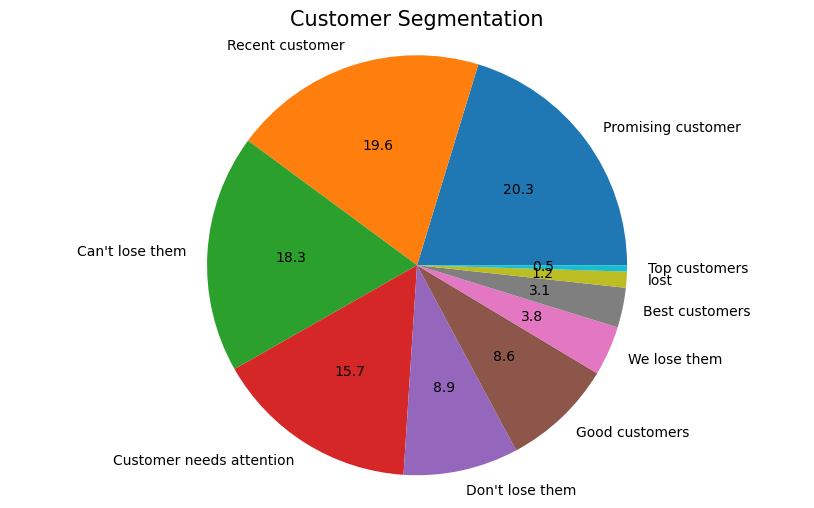

In [97]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Plot a pie chart based on the count of each customer segmentation category
final_rfm_df['Customer_Segmentation'].value_counts().plot(kind='pie', autopct='%.1f')
# Set the title of the pie chart
plt.title("Customer Segmentation", size=15)
# Remove the label on the y-axis
plt.ylabel(" ")
# Set the aspect ratio of the pie chart to be equal
plt.axis('equal') 
plt.show()


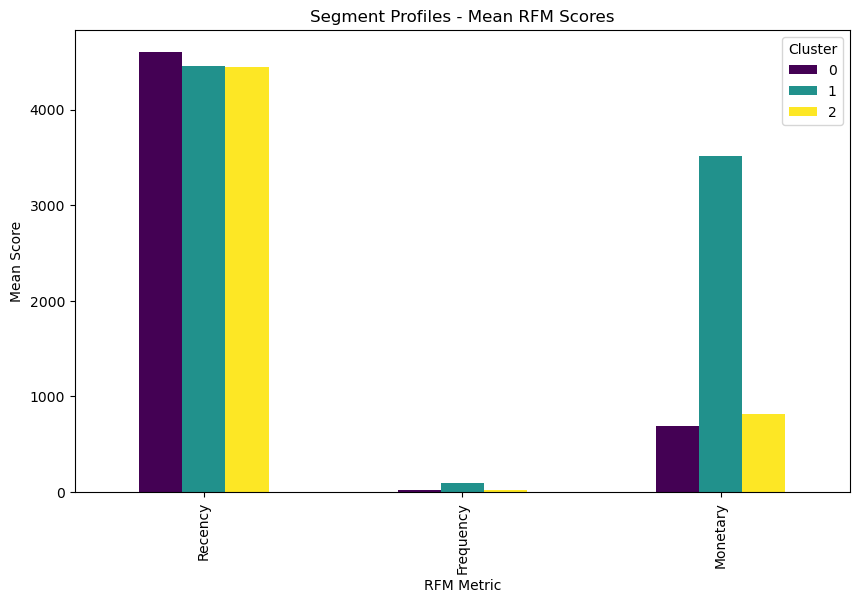

In [68]:
# Calculate mean RFM scores for each cluster
segment_profiles = final_rfm_df.groupby('Cluster')['Recency', 'Frequency', 'Monetary'].mean()

# Visualize the segment profiles
segment_profiles.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Segment Profiles - Mean RFM Scores')
plt.xlabel('RFM Metric')
plt.ylabel('Mean Score')
plt.show()

# CUSTOMER SEGMENTATION USING KNN 

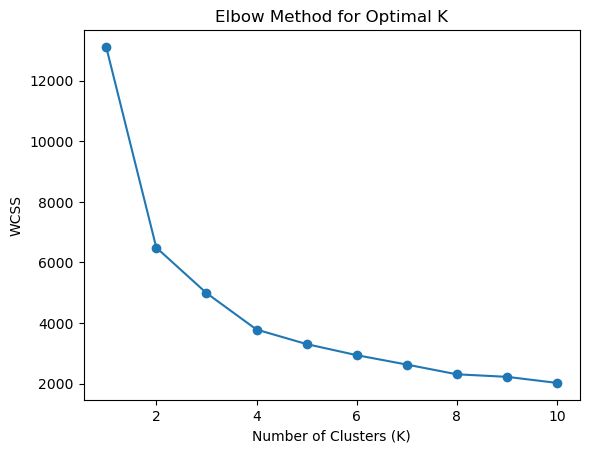

1    1829
0    1688
2     855
Name: Cluster, dtype: int64


In [98]:
# Extract the RFM scores for clustering
rfm_for_clustering = final_rfm_df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']]

# Standardize the data using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

# Calculate the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph to find the optimal number of clusters
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Choose the optimal number of clusters (e.g., 3 based on the elbow method)
optimal_k = 3

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
final_rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display the count of customers in each cluster
print(final_rfm_df['Cluster'].value_counts())

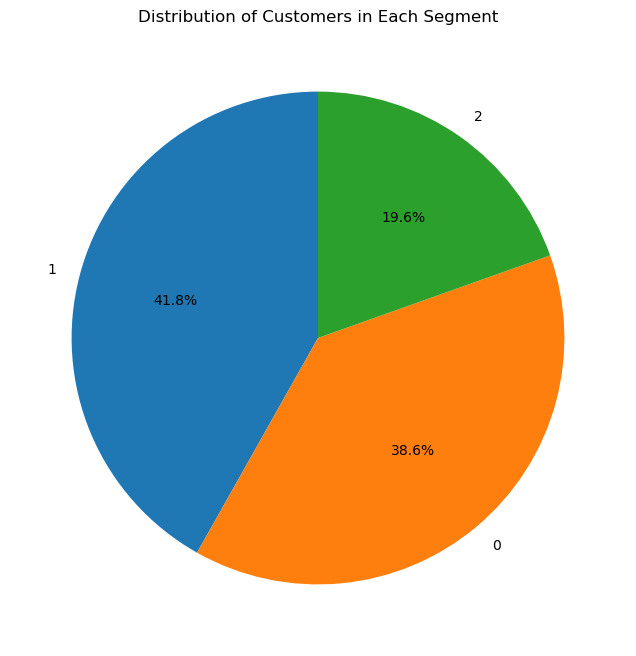

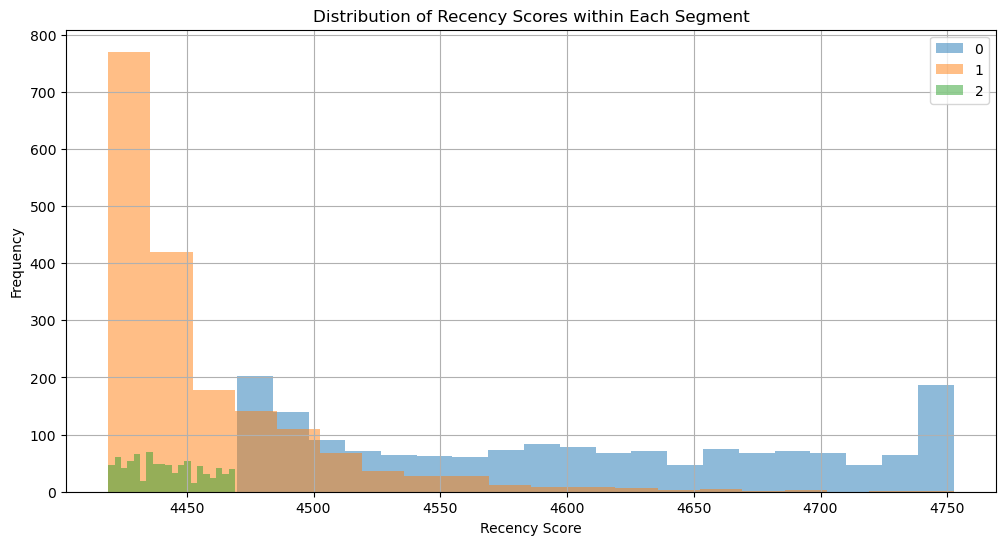

In [99]:
# Visualize the distribution of customers within each cluster
segment_counts = final_rfm_df['Cluster'].value_counts()
segment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.title('Distribution of Customers in Each Segment')
plt.ylabel('')
plt.show()

# Histogram of RFM scores within each cluster
final_rfm_df.groupby('Cluster')['Recency'].hist(alpha=0.5, bins=20, figsize=(12, 6))
plt.title('Distribution of Recency Scores within Each Segment')
plt.xlabel('Recency Score')
plt.ylabel('Frequency')
plt.legend(final_rfm_df['Cluster'].unique())
plt.show()


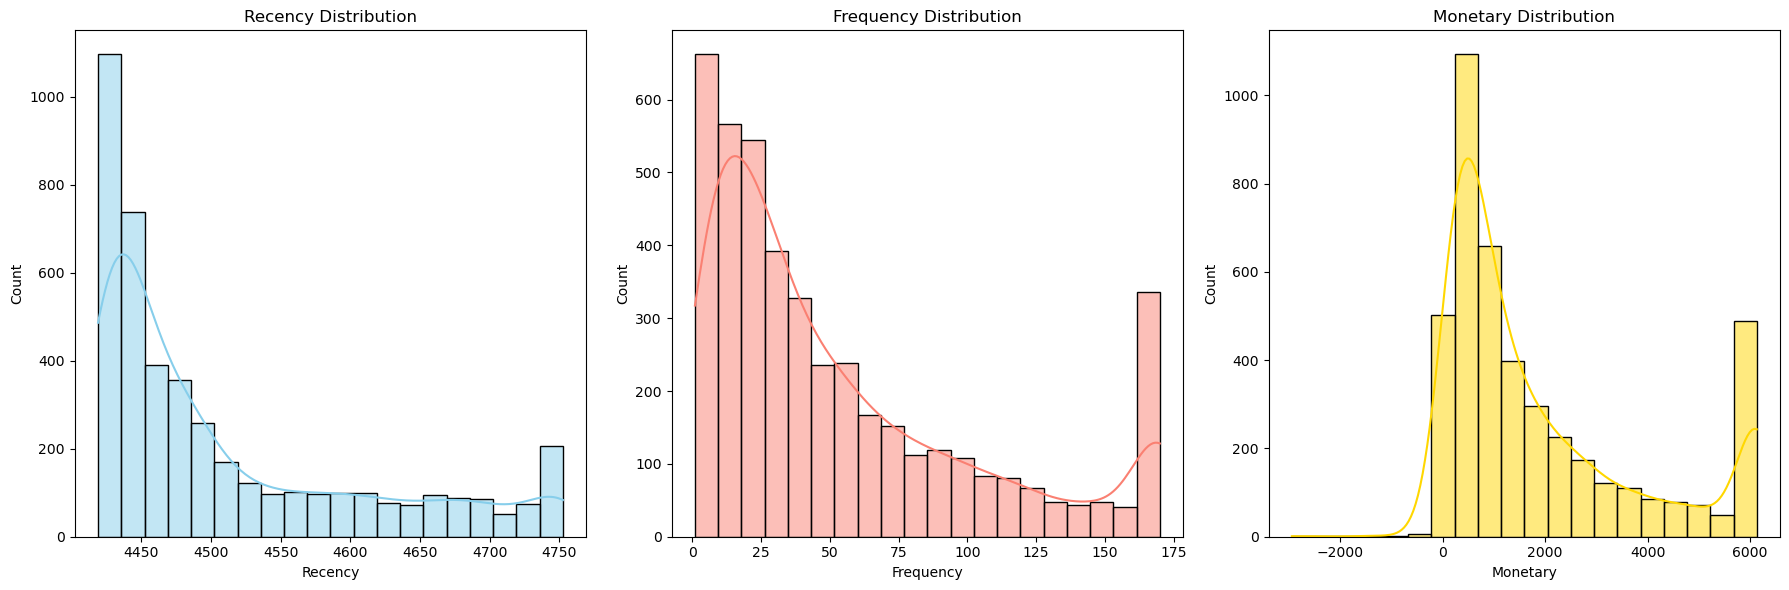

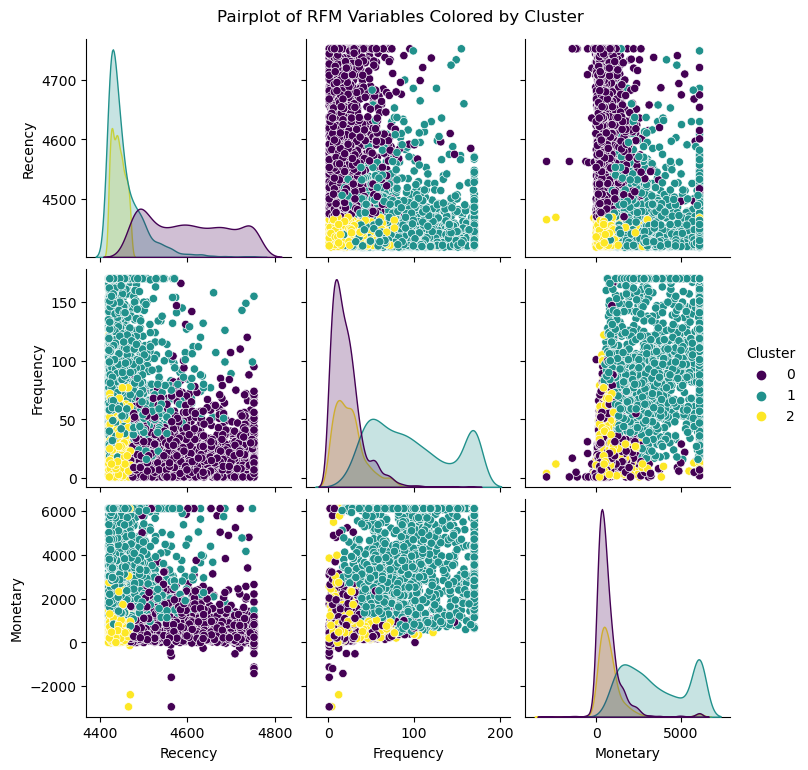

In [70]:
import seaborn as sns

# Plot RFM Distributions
plt.figure(figsize=(18, 6))

# Subplot for Recency
plt.subplot(1, 3, 1)
sns.histplot(final_rfm_df['Recency'], bins=20, kde=True, color='skyblue')
plt.title('Recency Distribution')

# Subplot for Frequency
plt.subplot(1, 3, 2)
sns.histplot(final_rfm_df['Frequency'], bins=20, kde=True, color='salmon')
plt.title('Frequency Distribution')

# Subplot for Monetary
plt.subplot(1, 3, 3)
sns.histplot(final_rfm_df['Monetary'], bins=20, kde=True, color='gold')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()


# Pairplot for RFM variables colored by cluster
sns.pairplot(final_rfm_df, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot of RFM Variables Colored by Cluster', y=1.02)
plt.show()

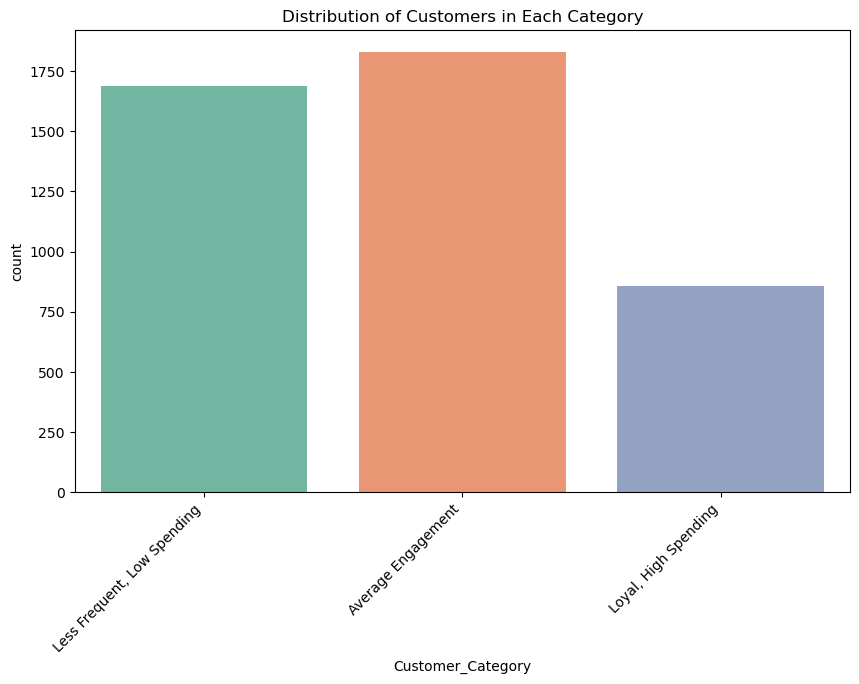

In [71]:
#Customer_segmentation

final_rfm_df['Customer_Category'] = final_rfm_df['Cluster'].map({
    0: 'Less Frequent, Low Spending',
    1: 'Average Engagement',
    2: 'Loyal, High Spending'
})

# Visualize the distribution of customers in each category
plt.figure(figsize=(10, 6))
sns.countplot(x='Customer_Category', data=final_rfm_df, palette='Set2')
plt.title('Distribution of Customers in Each Category')
plt.xticks(rotation=45, ha='right')
plt.show()


## DATA OVERVIEW

In [101]:
import pandas as pd

# Load the dataset
file_path = 'data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, encoding='ISO-8859-1')  # Using a different encoding if needed

# Dataset size in terms of rows and columns
rows, columns = data.shape

# Brief description of each column
column_descriptions = data.describe(include='all').T

# Assuming 'InvoiceDate' is the column to check for the time period
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Time period covered by the dataset
time_period = {
    'Start Date': data['InvoiceDate'].min(),
    'End Date': data['InvoiceDate'].max()
}

# Printing the results
print(f"Dataset Size: {rows} rows, {columns} columns")
print("\nColumn Descriptions:")
print(column_descriptions)
print("\nTime Period Covered by the Dataset:")
print(f"From {time_period['Start Date']} to {time_period['End Date']}")


Dataset Size: 541909 rows, 8 columns

Column Descriptions:
                count unique                                 top    freq  \
InvoiceNo      541909  25900                              573585    1114   
StockCode      541909   4070                              85123A    2313   
Description    540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369   
Quantity     541909.0    NaN                                 NaN     NaN   
InvoiceDate    541909  23260                    10/31/2011 14:41    1114   
UnitPrice    541909.0    NaN                                 NaN     NaN   
CustomerID   406829.0    NaN                                 NaN     NaN   
Country        541909     38                      United Kingdom  495478   

                    mean          std       min      25%      50%      75%  \
InvoiceNo            NaN          NaN       NaN      NaN      NaN      NaN   
StockCode            NaN          NaN       NaN      NaN      NaN      NaN   
Description          N

**Size of the Dataset:**

Number of Rows: 541,909
Number of Columns: 8


**Brief Description of Each Column:**

InvoiceNo: Identifier for each invoice (25,900 unique values).
StockCode: Product item code (4,070 unique values).
Description: Product description (4,223 unique descriptions; most frequent is "WHITE HANGING HEART T-LIGHT HOLDER").
Quantity: The quantities of each product per transaction (mean: ~9.55, min: -80,995, max: 80,995).
InvoiceDate: Date and time of the invoice (23,260 unique values).
UnitPrice: Price per unit (mean: ~4.61, min: -11,062.06, max: 38,970).
CustomerID: Identifier for each customer (mean ID: ~15287.69, min: 12,346, max: 18,287).
Country: Country name (38 unique countries; most frequent is the United Kingdom).

**Time Period Covered by the Dataset:**

The time period covered by the dataset is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00.

# EXPLORATORY DATA ANALYSIS

## CUSTOMER ANALYSIS 

### How many unique customers are there in the dataset?

In [116]:
unique_customers = data['CustomerID'].nunique()
unique_customers

4372

###  What is the distribution of the number of orders per customer?

In [119]:
# Group by CustomerID and count the unique InvoiceNo for each customer
orders_per_customer = data.groupby('CustomerID')['InvoiceNo'].nunique()
orders_per_customer

CustomerID
12346.0     2
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     3
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4372, dtype: int64

### Identify the top 5 customers by order count

In [121]:
top_5_customers = orders_per_customer.sort_values(ascending=False).head(5)
top_5_customers

CustomerID
14911.0    248
12748.0    224
17841.0    169
14606.0    128
13089.0    118
Name: InvoiceNo, dtype: int64

## PRODUCT ANALYSIS

### What are the top 10 most frequently purchased products?

In [103]:
# Group data by 'StockCode' and calculate the sum of 'Quantity' for each product
product_frequency = data.groupby('StockCode')['Quantity'].sum()

# Sort products based on their total quantity in descending order
product_frequency = product_frequency.sort_values(ascending=False)

# Select the top 10 most frequently purchased products
top_10_products = product_frequency.head(10)

# Print the top 10 most frequently purchased products
print("Top 10 most frequently purchased products:\n", top_10_products)


Top 10 most frequently purchased products:
 StockCode
22197     56450
84077     53847
85099B    47363
85123A    38830
84879     36221
21212     36039
23084     30646
22492     26437
22616     26315
21977     24753
Name: Quantity, dtype: int64


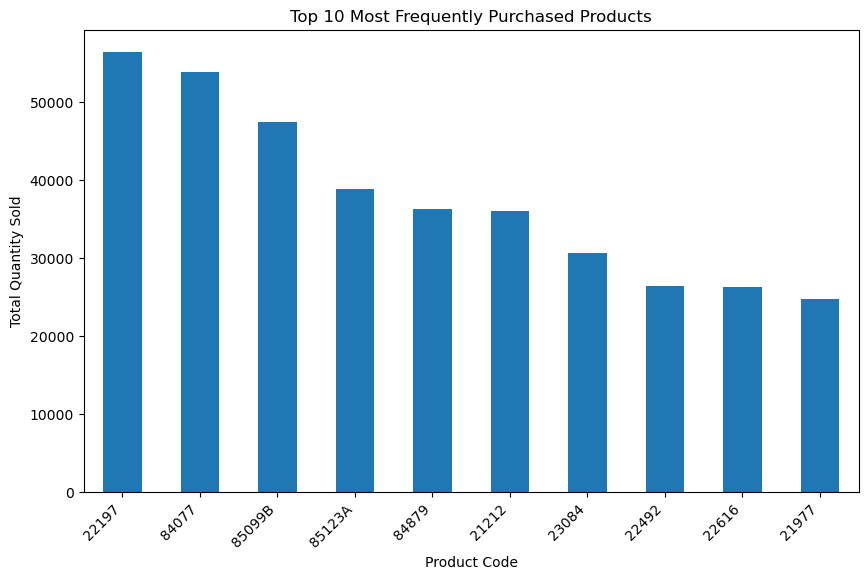

In [104]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Plot a bar chart for the top 10 most frequently purchased products
top_10_products.plot(kind='bar')
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Product Code')
plt.ylabel('Total Quantity Sold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

### What is the average price of products in the dataset?

In [105]:
# Calculate the average price of products
avg = data['UnitPrice'].mean()

# Print the average price
print("Average price of products:", avg)

Average price of products: 4.611113626088513


###  Can you find out which product category generates the highest revenue?

In [106]:
# Calculate the total revenue for each product category
data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']
category_revenue = data.groupby('StockCode')['TotalRevenue'].sum()

# Find the product category with the highest revenue and its total revenue value
highest_revenue_category = category_revenue.idxmax()
highest_revenue_value = category_revenue.max()

# Print the result
print("Product category with the highest revenue:", highest_revenue_category)
print("Total revenue for the category:", highest_revenue_value)

Product category with the highest revenue: DOT
Total revenue for the category: 206245.48


## TIME ANALYSIS

### Is there a specific day of the week or time of day when most orders are placed?

Number of Orders by Day of the Week:
 Thursday     103857
Tuesday      101808
Monday        95111
Wednesday     94565
Friday        82193
Sunday        64375
Name: DayOfWeek, dtype: int64

Number of Orders by Hour of the Day:
 12    78709
15    77519
13    72259
14    67471
11    57674
16    54516
10    49037
9     34332
17    28509
8      8909
18     7974
19     3705
20      871
7       383
6        41
Name: HourOfDay, dtype: int64


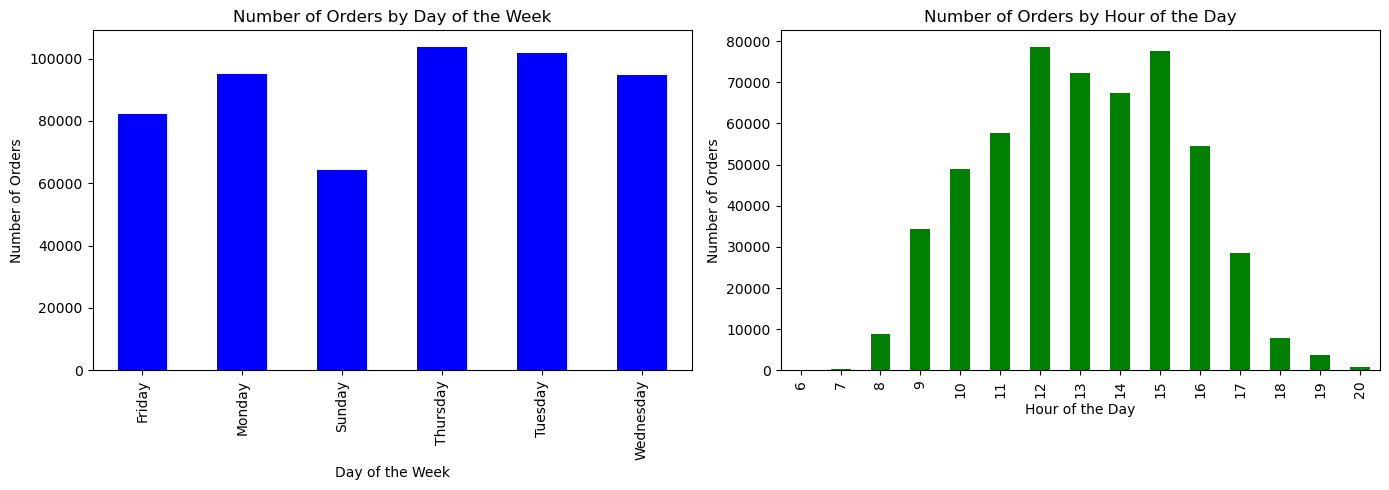

In [113]:
# Convert 'InvoiceDate' to datetime type if it's not already
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract day of the week and hour of the day
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['HourOfDay'] = data['InvoiceDate'].dt.hour

# Rest of your code remains unchanged
orders_by_day = data['DayOfWeek'].value_counts()
orders_by_hour = data['HourOfDay'].value_counts()
print("Number of Orders by Day of the Week:\n", orders_by_day)
print("\nNumber of Orders by Hour of the Day:\n", orders_by_hour)

# Plot bar charts to visualize the number of orders by day of the week and hour of the day
plt.figure(figsize=(14, 5))

# Subplot for number of orders by day of the week
plt.subplot(1, 2, 1)
orders_by_day.sort_index().plot(kind='bar', color='blue')
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')

# Subplot for number of orders by hour of the day
plt.subplot(1, 2, 2)
orders_by_hour.sort_index().plot(kind='bar', color='green')
plt.title('Number of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Are there any seasonal trends in the dataset?

Year  Month
2010  12        748957.020
2011  1         560000.260
      2         498062.650
      3         683267.080
      4         493207.121
      5         723333.510
      6         691123.120
      7         681300.111
      8         682680.510
      9        1019687.622
      10       1070704.670
      11       1461756.250
      12        433668.010
Name: TotalRevenue, dtype: float64


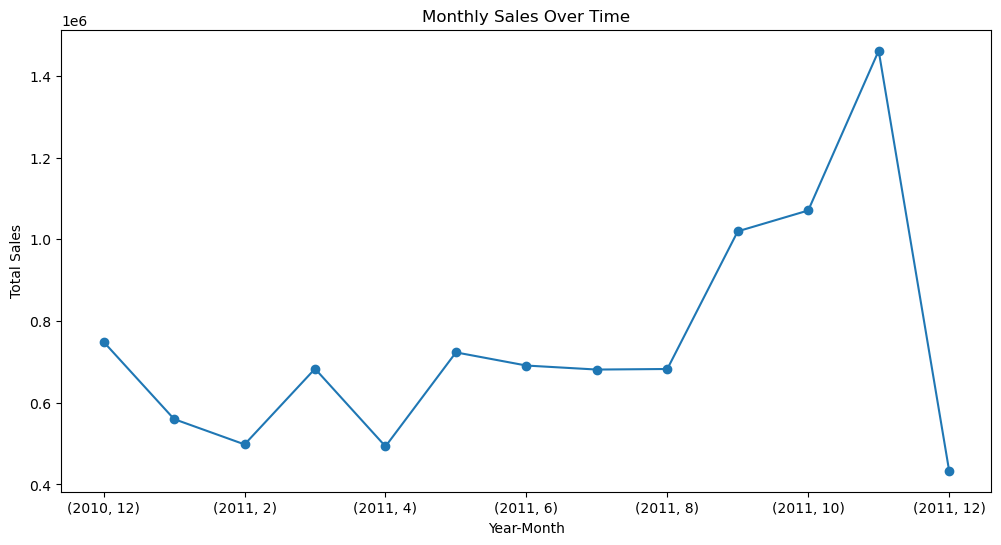

In [114]:
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()

monthly_sales = data.groupby(['Year', 'Month'])['TotalRevenue'].sum()
print(monthly_sales)

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.show()

## GEOGRAPHICAL ANALYSIS

### Can you determine the top 5 countries with the highest number of orders?

In [126]:
top_countries = df['Country'].value_counts().nlargest(5)
print("Top 5 countries with the highest number of orders:")
print(top_countries)

Top 5 countries with the highest number of orders:
United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Name: Country, dtype: int64


In [127]:
average_order_value_by_country = df.groupby('Country')['UnitPrice'].mean().sort_values(ascending=False)
print("\nAverage order value by country:")
print(average_order_value_by_country)


Average order value by country:
Country
Singapore               109.645808
Portugal                  8.771754
Cyprus                    6.350311
Canada                    6.030331
Norway                    6.012026
Finland                   5.448705
Lebanon                   5.387556
Malta                     5.244173
EIRE                      5.111607
France                    5.053124
Spain                     4.992682
Channel Islands           4.936460
Greece                    4.885548
Italy                     4.831121
European Community        4.820492
Bahrain                   4.644118
Brazil                    4.456250
RSA                       4.277586
Austria                   4.243192
Poland                    4.170880
Germany                   3.969772
Sweden                    3.914816
Israel                    3.670648
Belgium                   3.644335
Switzerland               3.499521
United Arab Emirates      3.380735
United Kingdom            3.268255
Denmark       

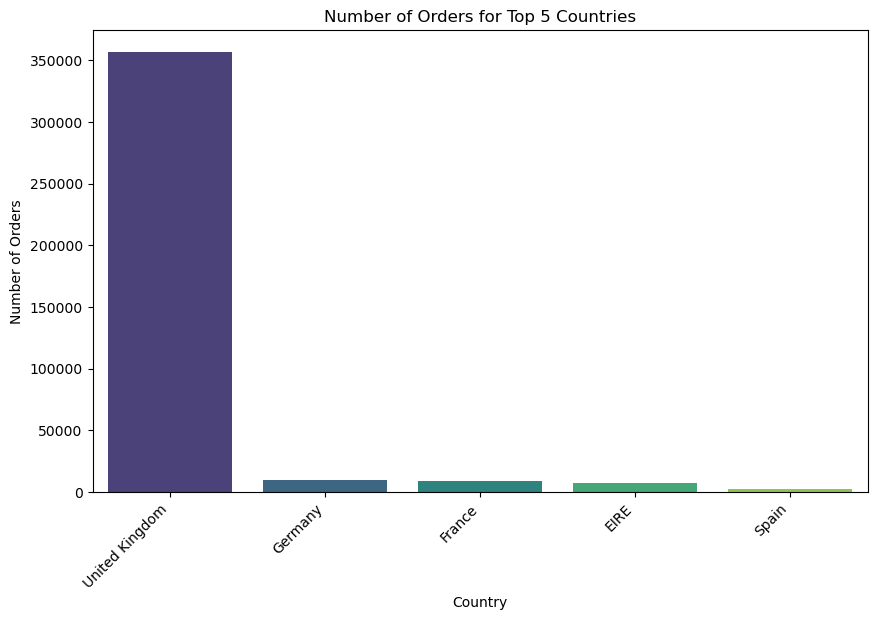

In [128]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Use seaborn's barplot to visualize the number of orders for top countries
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title('Number of Orders for Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.show()

### Is there a correlation between the country of the customer and the average order value?

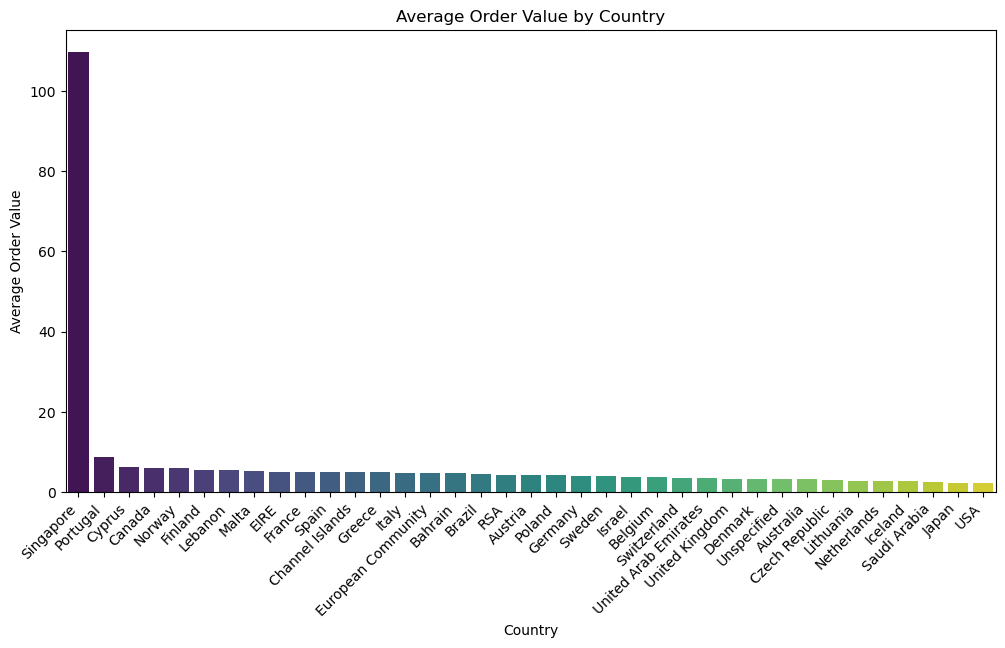

In [129]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Use seaborn's barplot to visualize the average order value by country
sns.barplot(x=average_order_value_by_country.index, y=average_order_value_by_country.values, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title('Average Order Value by Country')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.show()

In [130]:
# Calculate the average order value for each country
average_order_value_by_country = df.groupby('Country')['UnitPrice'].mean()

# Display the result
print("Average order value by country:")
print(average_order_value_by_country)

# Check correlation between country and average order value
correlation = df.groupby('Country')['UnitPrice'].mean().corr(df.groupby('Country')['UnitPrice'].count())

# Display correlation coefficient
print("Correlation between country and average order value:", correlation)


Average order value by country:
Country
Australia                 3.217806
Austria                   4.243192
Bahrain                   4.644118
Belgium                   3.644335
Brazil                    4.456250
Canada                    6.030331
Channel Islands           4.936460
Cyprus                    6.350311
Czech Republic            2.938333
Denmark                   3.256941
EIRE                      5.111607
European Community        4.820492
Finland                   5.448705
France                    5.053124
Germany                   3.969772
Greece                    4.885548
Iceland                   2.644011
Israel                    3.670648
Italy                     4.831121
Japan                     2.276145
Lebanon                   5.387556
Lithuania                 2.841143
Malta                     5.244173
Netherlands               2.738317
Norway                    6.012026
Poland                    4.170880
Portugal                  8.771754
RSA            

## PAYMENT ANALYSIS

### What are the most common payment methods used by customers?

In [133]:
# Infer payment methods based on 'InvoiceNo'
df['PaymentMethod'] = df['InvoiceNo'].apply(lambda x: 'Credit Card' if x.startswith('C') else 'Other')

# Check unique values in the inferred 'PaymentMethod' column
payment_methods = df['PaymentMethod'].unique()
print("Inferred Payment Methods:", payment_methods)


Inferred Payment Methods: ['Other' 'Credit Card']


In [134]:
# Analyze the frequency of inferred payment methods
payment_method_counts = df['PaymentMethod'].value_counts()
print("Payment method frequencies:")
print(payment_method_counts)

Payment method frequencies:
Other          392732
Credit Card      8872
Name: PaymentMethod, dtype: int64


In [135]:
# Check unique values in the 'PaymentMethod' column
unique_payment_methods = df['PaymentMethod'].unique()
print("All Unique Payment Methods:", unique_payment_methods)

All Unique Payment Methods: ['Other' 'Credit Card']


### Is there a relationship between the payment method and the order amount?


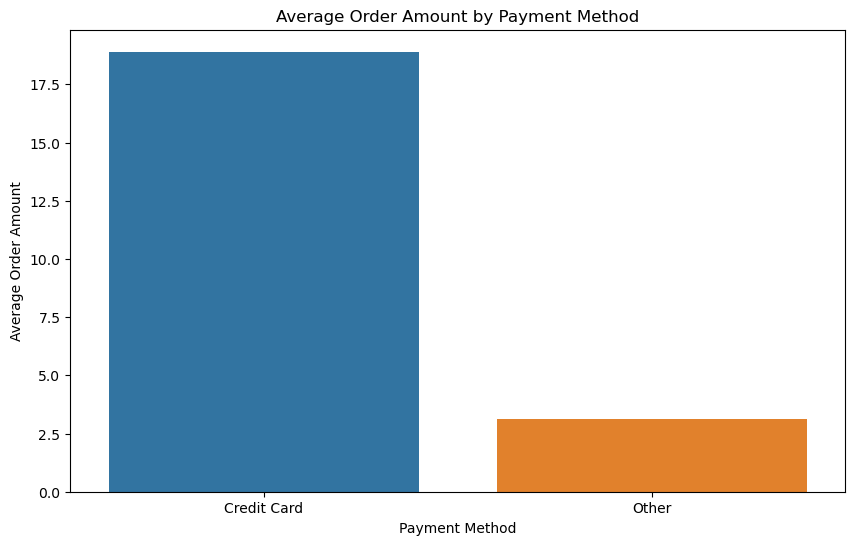

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by inferred payment method and calculate average order amount
average_order_amount_by_method = df.groupby('PaymentMethod')['UnitPrice'].mean()

# Visualize the relationship (for example, using a bar plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=average_order_amount_by_method.index, y=average_order_amount_by_method.values)
plt.xlabel('Payment Method')
plt.ylabel('Average Order Amount')
plt.title('Average Order Amount by Payment Method')
plt.show()

In [138]:
# Group by payment method and calculate summary statistics for order amount
order_amount_summary = df.groupby('PaymentMethod')['UnitPrice'].describe()
print("Summary Statistics for Order Amount by Payment Method:")
print(order_amount_summary)

Summary Statistics for Order Amount by Payment Method:
                  count       mean         std   min   25%   50%   75%  \
PaymentMethod                                                            
Credit Card      8872.0  18.899512  445.190864  0.01  1.45  2.95  4.95   
Other          392732.0   3.125596   22.240725  0.00  1.25  1.95  3.75   

                    max  
PaymentMethod            
Credit Card    38970.00  
Other           8142.75  


## CUSTOMER BEHAVIOUR 

### How long, on average, do customers remain active (between their first and lastpurchase) ?

In [140]:
# Import necessary libraries
import pandas as pd

# Assuming your dataset is in a variable named df
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the time between the first and last purchase for each customer
df['Lifespan'] = (df.groupby('CustomerID')['InvoiceDate'].transform('max') -
                  df.groupby('CustomerID')['InvoiceDate'].transform('min')).dt.days

# Calculate the average lifespan
average_lifespan = df['Lifespan'].mean()
print("Average Customer Lifespan:", average_lifespan)

Average Customer Lifespan: 242.61455065188593


## RETURNS AND REFUNDS

### What is the percentage of orders that have experienced returns or refunds?

In [143]:
#Create a new column 'Return' indicating whether Quantity is less than 0 (negative)

df['Return'] = df['Quantity'] < 0

# Calculate the percentage of orders with returns/refunds
return_percentage = (df[df['Return']].shape[0] / df.shape[0]) * 100

# Print the result
print("Percentage of Orders with Returns/Refunds:", return_percentage)

Percentage of Orders with Returns/Refunds: 2.209141343213713


### Is there a correlation between the product category and the likelihood of returns?

In [146]:
contingency_table = pd.crosstab(df['Description'], df['Return'])
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-square p-value:", p)

Chi-square p-value: 0.0


#### There is no correlation between he product category and the likelihood of returns

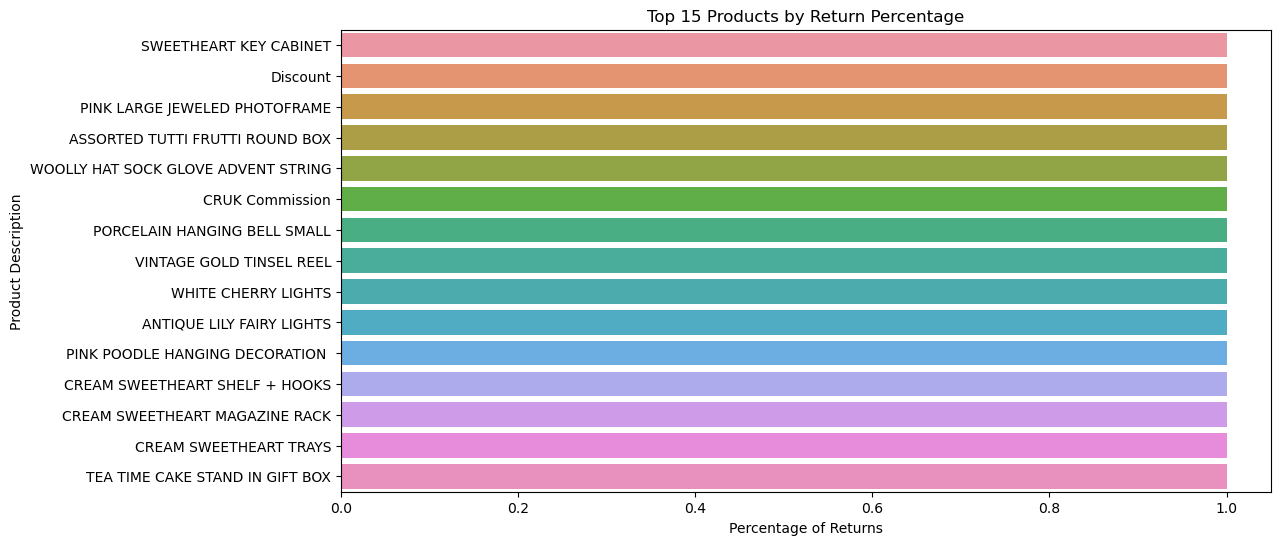

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot to visualize the percentage of returns by product description
return_percentage_by_product = df.groupby('Description')['Return'].mean().reset_index()
return_percentage_by_product = return_percentage_by_product.sort_values(by='Return', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Return', y='Description', data=return_percentage_by_product.head(15))
plt.title('Top 15 Products by Return Percentage')
plt.xlabel('Percentage of Returns')
plt.ylabel('Product Description')
plt.show()


## PROFITABILITY ANALYSIS

### Can you calculate the total profit generated by the company during the dataset's time period?

In [151]:
# Check for direct profit or profit margin columns
direct_profit_column = 'Profit' in df.columns
direct_profit_margin_column = 'Profit Margin' in df.columns

# Calculate total profit
if direct_profit_column:
    total_profit = df['Profit'].sum()
else:
    df['Profit'] = df['Quantity'] * df['UnitPrice']
    total_profit = df['Profit'].sum()

print("Total Profit:", total_profit)

Total Profit: 8278519.4240000015


### What are the top 5 products with the highest profit margins?

In [153]:
if direct_profit_margin_column:
    top_5_products = df[['Description', 'Profit Margin']].drop_duplicates().nlargest(5, 'Profit Margin')
else:
    # Assuming profit margin is represented by UnitPrice
    df['Profit Margin'] = df['UnitPrice']
    top_5_products = df[['Description', 'Profit Margin']].drop_duplicates().nlargest(5, 'Profit Margin')

# Display results
print("Top 5 Products with Highest Profit Margins:")
print(top_5_products)

Top 5 Products with Highest Profit Margins:
       Description  Profit Margin
222681      Manual       38970.00
173277     POSTAGE        8142.75
173391      Manual        6930.00
268027      Manual        4287.63
422351      Manual        4161.06


## CUSTOMER SATISFACTION

### Is there any data available on customer feedback or ratings for products or services?

In [155]:
import numpy as np
df['CustomerRating'] = np.random.randint(1, 6, size=len(df))

In [156]:
# Analyze the simulated customer satisfaction
average_rating = df['CustomerRating'].mean()
print("\nAverage Customer Rating:", average_rating)


Average Customer Rating: 3.0029506678220335


#### There is no data available on customer feedback or ratings for products or services, therefore we generate our own based using random function.

### Can you analyze the sentiment or feedback trends, if available?

In [159]:
rating_distribution = df['CustomerRating'].value_counts()
print("\nRating Distribution:")
print(rating_distribution)


Rating Distribution:
3    80697
4    80444
5    80355
2    80247
1    79861
Name: CustomerRating, dtype: int64


## RECOMMENDATIONS FOR EACH CLUSTER ( KNN CLUSTERING)

1. Less Often, Lower Expenditure  (Cluster 0):

Re-Engagement Campaigns: To remind clients about your goods and services, start focused re-engagement campaigns.
Exclusive Discounts: To encourage more regular purchases, offer exclusive discounts or promotions.
Product Suggestions: Present products that you think they might find interesting by making personalized product suggestions.


2. Average Engagement Customers ( Good Customers) (Cluster 1):

Loyalty Programs: Establish a loyalty program to reward sustained involvement and promote repeat business.
Cross-Sell Techniques: To raise average transaction values, find comparable products and use cross-selling techniques.
Customer surveys: Use them to get input and make improvements to any areas that may be impeding greater levels of involvement.

3. Loyal, High spending Customers (Loyal Customers) (Cluster 2):

VIP Programs: Upgrade their experience by providing early access, special benefits, and first-rate services through a VIP program.
Personalized Communication: Recognize their devotion and make suggestions for upscale products in marketing messages that are tailored to them with specific information.
Referral Programs: Use referral programs with alluring incentives to take advantage of their loyalty to bring in new clients.